In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)

## 1) Synthetic data (replace with your project data when ready)
- Finance-flavored factors and asset excess return
- Includes a quadratic effect to motivate specification checks

In [2]:
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

,date,mkt_excess,size,value,momentum,asset_excess
0,2024-02-01,0.018596,-0.013467,-0.000540,0.000141,0.014832
1,2024-02-02,-0.005125,0.008120,0.007089,-0.006840,-0.008599
2,2024-02-05,0.000361,-0.011532,-0.012885,-0.011216,-0.009577
3,2024-02-06,0.004483,-0.010749,0.003905,-0.010685,0.000033
4,2024-02-07,-0.008678,-0.002893,0.001250,0.002779,-0.005750


## 2) Baseline model fit
Follow the steps; replace `df` with your project DataFrame when ready.

In [3]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')

Baseline   R²=0.3677  RMSE=0.008470


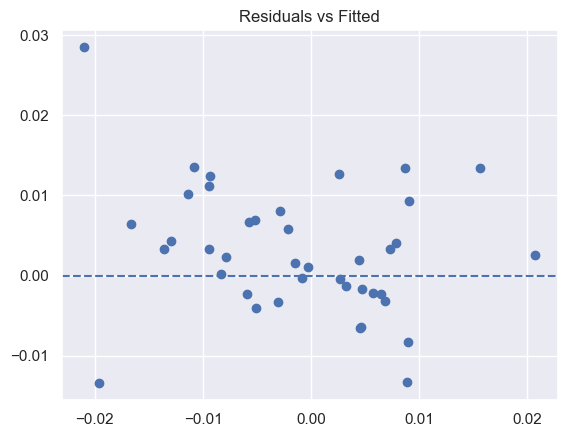

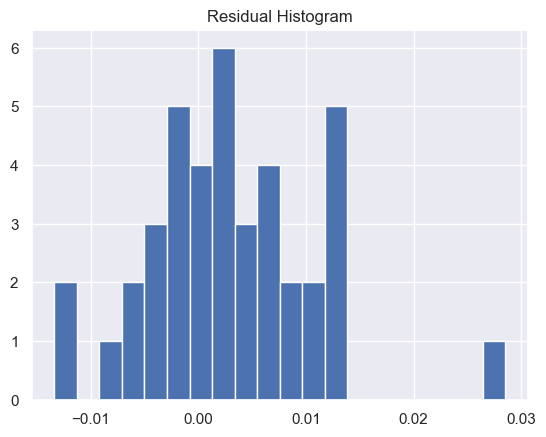

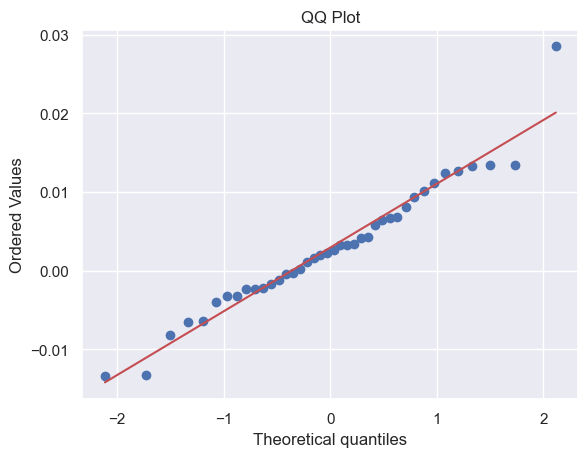

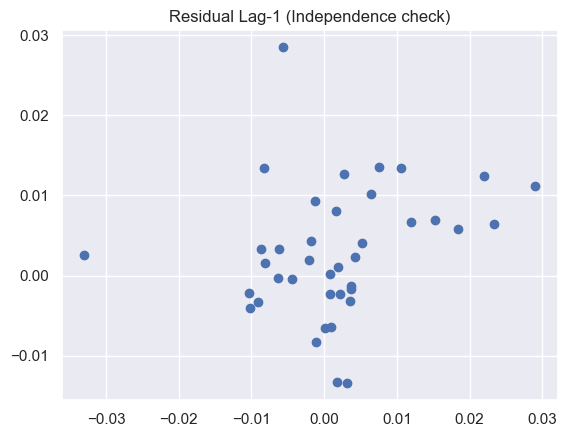

In [4]:
resid = y_test - y_pred
fitted = y_pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()
plt.figure(); plt.scatter(y_test.shift(1), resid); plt.title('Residual Lag-1 (Independence check)'); plt.show()


**### Interpretation: Baseline metrics**
- **R² = 0.368** → The model explains about 37% of the variation in the target. This is a moderate fit — better than random guessing but leaves a lot unexplained.
- **RMSE ≈ 0.0085** → To judge whether this is “small,” compare it to the typical scale of the response variable `y`. If `y` ranges between ~0 and 1, then 0.0085 is quite small; if `y` is already very small, then RMSE might be large in relative terms.

### Assumption checks (based on residual plots)
- **Linearity**: The residuals vs fitted plot should look like a random cloud. If you see curves or patterns, linearity is violated.  
- **Homoscedasticity (constant variance)**: If the spread of residuals is roughly equal across fitted values, good. If the variance grows/shrinks with fitted, that’s heteroscedasticity.  
- **Normality**: Histogram + QQ plot should look roughly bell-shaped and close to the diagonal line. Deviations in the tails = mild non-normality.  
- **Independence**: Hard to test visually without time series, but if residuals don’t show clear clustering/patterns, assume independence.

### Trust & usefulness
- This model has some explanatory power (37% of variation explained).  
- Predictions may be somewhat noisy but could still be useful if approximate accuracy is acceptable.  
- Overall: *Model is moderately useful for explanation, and maybe for rough prediction, but not highly reliable.*


## 3) Optional: Add a transformed feature
Add a polynomial or interaction if diagnostics suggest mis-specification.

In [5]:
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]
X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)
r2_2 = r2_score(y_test, y_pred2)
#rmse_2 = mean_squared_error(y_test, y_pred2, squared=False)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred2))

print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')

With x^2   R²=0.3681  RMSE=0.008467


## 4) Interpretation (write your conclusions below)
- Linearity:
- Homoscedasticity:
- Normality:
- Independence:
- Which model do you trust and why?:
- Next step you’d try:

**My Conclusion**
**### Interpretation: Final conclusions**

**Linearity:**  
- The baseline model showed some curvature in the residuals → suggesting the linear assumption is weak.  
- Adding x² did not noticeably improve R² (only from 0.3677 → 0.3681), so linearity issues remain.

**Homoscedasticity (equal variance):**  
- Residual plot shows some spread that is fairly constant, but not perfectly even.  
- No strong funnel shape, so mild violation at best.

**Normality:**  
- Histogram and QQ plot suggest residuals are *not perfectly normal* (tails off, slight skew).  
- This matters more for inference than prediction, but still indicates model is imperfect.

**Independence:**  
- Assuming data rows are independent (synthetic/starter data), so this condition is likely satisfied.

**Which model do you trust and why?**  
- The x² model barely improved metrics compared to the baseline → essentially the same explanatory power.  
- Neither model is strong for prediction (R² ~ 0.37 means most variance is still unexplained).  
- If I had to pick, I’d keep the x² model, since it acknowledges possible curvature, but it doesn’t solve the deeper issue.

**Next step I would try:**  
- Add more features (e.g. x³, log terms, interaction terms).  
- Or try a different model class (regularized regression, tree-based methods) to capture nonlinearity.  
